# Парсер HeadHunter
## Цель электива:
* Сделать парсер, чтобы получать те вакансии, которые интересны именно тебе

## Что для этого будем использовать?
* requests - для отправки запросов к API HH
* json - для декодирования ответов в удобном формате
* pandas - для формирования таблицы 
* matplotlib, seaborn - визуализация
* IPython для магических штук

### Импорт библиотек

In [1]:
import requests
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import time

from IPython.core.display import display, HTML, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 30)

Необходимые пакеты:

In [2]:
!pip freeze

alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client==1.7.2
anaconda-navigator==2.1.0
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1610472525955/work
anyio @ file:///C:/ci/anyio_1620153418380/work/dist
appdirs==1.4.4
argh==0.26.2
argon2-cffi @ file:///C:/ci/argon2-cffi_1613037959010/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astroid @ file:///C:/ci/astroid_1613501047216/work
astropy @ file:///C:/ci/astropy_1617745647203/work
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1604765588209/work
autopep8 @ file:///tmp/build/80754af9/autopep8_1615918855173/work
Babel @ file:///tmp/build/80754af9/babel_1607110387436/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
backports.functools-lru-cache @ file:///tmp/build/80754af9/backports.functools_lru_cache_1618170165463/work
backports.shutil-get-terminal-

### Делаем выгрузку из HeadHunter
Ссылка на API: https://github.com/hhru/api \
Для того, чтобы написать запрос используется язык поисковых запросов, задокументированный тут: https://hh.ru/article/1175 \
Фильтрацию можно делать в самом запросе, например, сделать поиск по полю компаний или же по наличию конкретного текста в описании, где COMPANY_NAME - название компании, а DESCRIPTION - описание вакансии. Причем интересно, что этот язык запросов работает и на обычном сайте hh.ru, что бывает иногда полезно

Создадим необходимые константы: BASE_URL

In [3]:
BASE_URL = "https://api.hh.ru/"
TEXT = f'NAME:("Data Scientist" or "Дата саентист" or "Искусственный интеллект" or "Машинное обучение" or "Data Science" or "Data Engineer" or "Data инженер" or "Инженер данных")'
dt_now = datetime.now().date()
dt_from = dt_now - timedelta(days=7)
DATE_TO = '%s-%02d-%02d' % (dt_now.year, dt_now.month, dt_now.day)
DATE_FROM = '%s-%02d-%02d' % (dt_from.year, dt_from.month, dt_from.day)

VAC_URL = BASE_URL + f'vacancies?text={TEXT}&date_from={DATE_FROM}&date_to={DATE_TO}&responses_count_enabled=True&per_page=100'

In [7]:
# проверка
DATE_FROM, DATE_TO, VAC_URL

('2022-01-21',
 '2022-01-28',
 'https://api.hh.ru/vacancies?text=NAME:("Data Scientist" or "Дата саентист" or "Искусственный интеллект" or "Машинное обучение" or "Data Science" or "Data Engineer" or "Data инженер" or "Инженер данных")&date_from=2022-01-21&date_to=2022-01-28&responses_count_enabled=True&per_page=100')

Создадим пустой датафрейм `vacancy_df`:

In [11]:
vacancy_df = pd.DataFrame()

В выдаче апи hh нет опыта, поэтому укажем его в запросе:\
Здесь можно выбрать необходимый или указать все. Важно помнить, что можно откликаться на вакансии с "от 1 года опыта".

In [9]:
experiences = ['noExperience',
               'between1And3']

#                'between3And6', 
#                'moreThan6'

Напишем цикл, который добавит информацию об опыте в строку запроса, пройдет по страницам и добавит отфильтрованные вакансии в датасет `vacancy_df`:

In [12]:
for exp in experiences:
#     начнем с нулевой страницы
    page = 0
#     добавим опыт в строку запроса
    url = VAC_URL + f'&experience={exp}'
    try:
#         Запрос с указанием номера страницы
        r = requests.get(url + f'&page={page}')
#         Считывание и запись в переменную `data`
        data = json.loads(r.text)
        print('Количество страниц ', exp, data['pages'])
#         Интересующая колонка - `items`, поэтому запишем её в одноименную переменную.
        items = data['items']
#         Аналогично в цикле сделаем для остальных страниц, начиная уже с 1й
        for page in range(1, data['pages']):
            r = requests.get(url + f'&page={page}')
            data = json.loads(r.text)
#         Добавляем в `items` информацию с каждой следующей страницы
            items += data['items']
#     запишем items в датасет `df`
        df = pd.DataFrame(items)
#     добавим в `df` столбец с указанием опыта, по которому осуществлялся поиск
        df['experience'] = exp
#     складываем собранную информацию в `df` в наш основной датасет `vacancy_df`
        vacancy_df = pd.concat([vacancy_df, df])
    except Exception as e:
#     в случае возникновения ошибки выводим ошибку
        print(e)

Количество страниц  noExperience 1
Количество страниц  between1And3 4


Посмотрим на первые 5 строк получившегося датасета:

In [13]:
vacancy_df.head()

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,alternate_url,relations,employer,snippet,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience
0,51038023,False,Data Engineer,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-28T13:00:41+0300,2022-01-28T13:00:41+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/51038023?host=hh.ru,https://hh.ru/vacancy/51038023,[],"{'id': '49556', 'name': 'Dell Technologies, Це...",{'requirement': '5 yrs of relevant experience ...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 13},[],[],[],False,noExperience
1,51906822,False,Data Scientist,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '3', 'name': 'Екатеринбург', 'url': 'ht...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-28T16:46:15+0300,2022-01-28T16:46:15+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/51906822?host=hh.ru,https://hh.ru/vacancy/51906822,[],"{'id': '3529', 'name': 'Сбербанк', 'url': 'htt...",{'requirement': 'Знание математической статист...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 3},[],[],[],False,noExperience
2,51045137,False,Data Scientist,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 1000, 'to': 1500, 'currency': 'EUR', ...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-28T14:42:53+0300,2022-01-28T14:42:53+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/51045137?host=hh.ru,https://hh.ru/vacancy/51045137,[],"{'id': '5407422', 'name': 'Verfacto', 'url': '...",{'requirement': 'Образование: ведущие универси...,None,"{'id': 'flexible', 'name': 'Гибкий график'}",{'responses': 306},[],[],[],True,noExperience
3,51886558,False,Junior Data Engineer / Junior Developer,None,False,False,"{'id': '53', 'name': 'Краснодар', 'url': 'http...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-28T11:11:12+0300,2022-01-28T11:11:12+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/51886558?host=hh.ru,https://hh.ru/vacancy/51886558,[],"{'id': '4080', 'name': 'Accenture', 'url': 'ht...",{'requirement': 'Освоить навыки разработки. Зд...,None,"{'id': 'remote', 'name': 'Удаленная работа'}",{'responses': 53},[],[],[],False,noExperience
4,51880953,False,Junior Data Engineer / Junior Developer,None,False,False,"{'id': '76', 'name': 'Ростов-на-Дону', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Ростов-на-Дону', 'street': 'Нижнебул...",None,None,2022-01-28T09:25:57+0300,2022-01-28T09:25:57+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/51880953?host=hh.ru,https://hh.ru/vacancy/51880953,[],"{'id': '4080', 'name': 'Accenture', 'url': 'ht...",{'requirement': 'Освоить навыки разработки. Зд...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 22},[],[],[],False,noExperience


Сбросим индексы на случай возникновения мультииндексов:

In [14]:
vacancy_df.reset_index(drop=True, inplace=True)

In [16]:
vacancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        371 non-null    object
 1   premium                   371 non-null    bool  
 2   name                      371 non-null    object
 3   department                83 non-null     object
 4   has_test                  371 non-null    bool  
 5   response_letter_required  371 non-null    bool  
 6   area                      371 non-null    object
 7   salary                    89 non-null     object
 8   type                      371 non-null    object
 9   address                   146 non-null    object
 10  response_url              0 non-null      object
 11  sort_point_distance       0 non-null      object
 12  published_at              371 non-null    object
 13  created_at                371 non-null    object
 14  archived                  

In [17]:
vacancy_df.head()

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,alternate_url,relations,employer,snippet,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience
0,51038023,False,Data Engineer,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-28T13:00:41+0300,2022-01-28T13:00:41+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/51038023?host=hh.ru,https://hh.ru/vacancy/51038023,[],"{'id': '49556', 'name': 'Dell Technologies, Це...",{'requirement': '5 yrs of relevant experience ...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 13},[],[],[],False,noExperience
1,51906822,False,Data Scientist,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '3', 'name': 'Екатеринбург', 'url': 'ht...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-28T16:46:15+0300,2022-01-28T16:46:15+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/51906822?host=hh.ru,https://hh.ru/vacancy/51906822,[],"{'id': '3529', 'name': 'Сбербанк', 'url': 'htt...",{'requirement': 'Знание математической статист...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 3},[],[],[],False,noExperience
2,51045137,False,Data Scientist,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 1000, 'to': 1500, 'currency': 'EUR', ...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-28T14:42:53+0300,2022-01-28T14:42:53+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/51045137?host=hh.ru,https://hh.ru/vacancy/51045137,[],"{'id': '5407422', 'name': 'Verfacto', 'url': '...",{'requirement': 'Образование: ведущие универси...,None,"{'id': 'flexible', 'name': 'Гибкий график'}",{'responses': 306},[],[],[],True,noExperience
3,51886558,False,Junior Data Engineer / Junior Developer,None,False,False,"{'id': '53', 'name': 'Краснодар', 'url': 'http...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-28T11:11:12+0300,2022-01-28T11:11:12+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/51886558?host=hh.ru,https://hh.ru/vacancy/51886558,[],"{'id': '4080', 'name': 'Accenture', 'url': 'ht...",{'requirement': 'Освоить навыки разработки. Зд...,None,"{'id': 'remote', 'name': 'Удаленная работа'}",{'responses': 53},[],[],[],False,noExperience
4,51880953,False,Junior Data Engineer / Junior Developer,None,False,False,"{'id': '76', 'name': 'Ростов-на-Дону', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Ростов-на-Дону', 'street': 'Нижнебул...",None,None,2022-01-28T09:25:57+0300,2022-01-28T09:25:57+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/51880953?host=hh.ru,https://hh.ru/vacancy/51880953,[],"{'id': '4080', 'name': 'Accenture', 'url': 'ht...",{'requirement': 'Освоить навыки разработки. Зд...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 22},[],[],[],False,noExperience


Видим, что есть столбцы, значения которых представлены в виде словарей.

### Вытащим ценную информацию из словарей

Напишем функцию, которая будет возвращать значение по `id`, либо `nan`, если его нет.

In [18]:
def return_id(x, key='id', nan_value=np.nan):
    try:
        return x[key]
    except Exception as e:
        return nan_value

Применим функцию к интересующим нам столбцам со словарями:

In [19]:
vacancy_df['employer_name'] = vacancy_df['employer'].apply(return_id, key='name')
vacancy_df['department_name'] = vacancy_df['department'].apply(return_id, key='name')
vacancy_df['salary_from'] = vacancy_df['salary'].apply(return_id, key='from')
vacancy_df['salary_to'] = vacancy_df['salary'].apply(return_id, key='to')
vacancy_df['salary_gross'] = vacancy_df['salary'].apply(return_id, key='gross')
vacancy_df['salary_currency'] = vacancy_df['salary'].apply(return_id, key='currency')
vacancy_df['counters'] = vacancy_df['counters'].apply(return_id, key='responses')
vacancy_df['city'] = vacancy_df['area'].apply(return_id, key='name')

In [20]:
vacancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        371 non-null    object 
 1   premium                   371 non-null    bool   
 2   name                      371 non-null    object 
 3   department                83 non-null     object 
 4   has_test                  371 non-null    bool   
 5   response_letter_required  371 non-null    bool   
 6   area                      371 non-null    object 
 7   salary                    89 non-null     object 
 8   type                      371 non-null    object 
 9   address                   146 non-null    object 
 10  response_url              0 non-null      object 
 11  sort_point_distance       0 non-null      object 
 12  published_at              371 non-null    object 
 13  created_at                371 non-null    object 
 14  archived  

In [21]:
vacancy_df.head(10)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,...,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,city
0,51038023,False,Data Engineer,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-28T13:00:41+0300,2022-01-28T13:00:41+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",13,[],[],[],False,noExperience,"Dell Technologies, Центр Разработок",NaN,NaN,NaN,NaN,NaN,Санкт-Петербург
1,51906822,False,Data Scientist,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '3', 'name': 'Екатеринбург', 'url': 'ht...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-28T16:46:15+0300,2022-01-28T16:46:15+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",3,[],[],[],False,noExperience,Сбербанк,Сбер для экспертов,NaN,NaN,NaN,NaN,Екатеринбург
2,51045137,False,Data Scientist,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 1000, 'to': 1500, 'currency': 'EUR', ...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-28T14:42:53+0300,2022-01-28T14:42:53+0300,False,...,None,"{'id': 'flexible', 'name': 'Гибкий график'}",306,[],[],[],True,noExperience,Verfacto,NaN,1000.0,1500.0,True,EUR,Москва
3,51886558,False,Junior Data Engineer / Junior Developer,None,False,False,"{'id': '53', 'name': 'Краснодар', 'url': 'http...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-28T11:11:12+0300,2022-01-28T11:11:12+0300,False,...,None,"{'id': 'remote', 'name': 'Удаленная работа'}",53,[],[],[],False,noExperience,Accenture,NaN,NaN,NaN,NaN,NaN,Краснодар
4,51880953,False,Junior Data Engineer / Junior Developer,None,False,False,"{'id': '76', 'name': 'Ростов-на-Дону', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Ростов-на-Дону', 'street': 'Нижнебул...",None,None,2022-01-28T09:25:57+0300,2022-01-28T09:25:57+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",22,[],[],[],False,noExperience,Accenture,NaN,NaN,NaN,NaN,NaN,Ростов-на-Дону
5,49514879,False,Junior Data Engineer,None,False,False,"{'id': '115', 'name': 'Киев', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Киев', 'street': 'Оболонско-Теремков...",None,None,2022-01-27T17:30:53+0300,2022-01-27T17:30:53+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",13,[],[],[],False,noExperience,SocialTech,NaN,NaN,NaN,NaN,NaN,Киев
6,51346006,False,Младший аналитик / Data scientist,None,True,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Новодмитровская ...",None,None,2022-01-28T14:18:19+0300,2022-01-28T14:18:19+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",58,[],[],[],False,noExperience,ЭКОПСИ Консалтинг,NaN,NaN,NaN,NaN,NaN,Москва
7,50015747,False,Оператор выдувных машин (обучение),None,False,False,"{'id': '1126', 'name': 'Ангарск', 'url': 'http...","{'from': 35000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Ангарск', 'street': '94-й квартал', ...",None,None,2022-01-28T10:18:37+0300,2022-01-28T10:18:37+0300,False,...,None,"{'id': 'shift', 'name': 'Сменный график'}",1,[],[],[],False,noExperience,Успех,NaN,35000.0,NaN,False,RUR,Ангарск
8,50562309,False,Data Scientist,"{'id': 'slum-2791-office', 'name': 'Schlumberg...",False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'улица Зелён...",None,None,2022-01-27T10:35:24+0300,2022-01-27T10:35:24+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",6,[],[],[],False,noExperience,Шлюмберже,Schlumberger Telecommunications and Informatio...,NaN,NaN,NaN,N

### Про дубликаты

Посмотрим на дубликаты:

In [22]:
vacancy_df[vacancy_df.duplicated(['employer_name', 'name'], keep=False)][['employer_name', 'name', 'city', 'experience']].sort_values(by=['name'])

,employer_name,name,city,experience
74,Accenture,Big Data Engineer,Санкт-Петербург,between1And3
213,Accenture,Big Data Engineer,Ростов-на-Дону,between1And3
214,Accenture,Big Data Engineer,Краснодар,between1And3
38,Ozon,"Big Data Engineer, Ozon Express",Нижний Новгород,noExperience
37,Ozon,"Big Data Engineer, Ozon Express",Самара,noExperience
...,...,...,...,...
295,Деметра Трейдинг,Инженер баз данных / Data engineer,Краснодар,between1And3
306,Яндекс.Практикум,"Ревьюер на курс по ""Data Engineering""",Москва,between1And3
307,Яндекс.Практикум,"Ревьюер на курс по ""Data Engineering""",Санкт-Петербург,between1And3
360,Ozon,"Руководитель группы Data scientist, Ozon Express",Иннополис,between1And3


Видим, что есть вакансии, совпадающие полностью, кроме города. Это говорит о том, что компания может опубликовать свою вакансию в разных городах, чтобы охватить как можно больше соискателей.

### Посмотрим компании, предлагающие вакансии, а также города

Количество вакансий по имени компании:

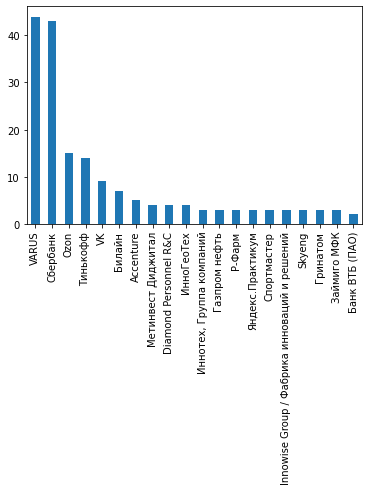

In [26]:
vacancy_df['employer_name'].value_counts().head(20).plot(kind='bar');

По названию департамента:

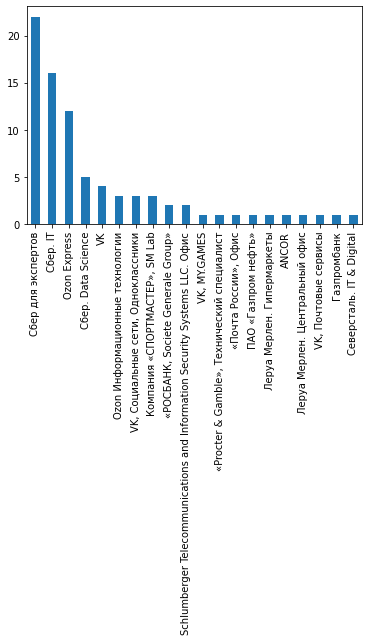

In [28]:
vacancy_df['department_name'].value_counts().head(20).plot(kind='bar');

По городам:

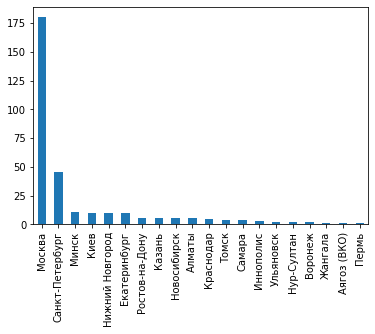

In [29]:
vacancy_df['city'].value_counts().head(20).plot(kind='bar');

### Что с зарплатой?

In [30]:
vacancy_df['salary_from'].isna().value_counts(normalize=True)

True     0.781671
False    0.218329
Name: salary_from, dtype: float64

Зарплата указана в 78%, остальные - без.

In [31]:
vacancy_df['salary_currency'].value_counts(normalize=True)

USD    0.516854
RUR    0.460674
KZT    0.011236
EUR    0.011236
Name: salary_currency, dtype: float64

Больше половины зарплат в долларах. На втором месте российский рубль - 46%.

Посмотирим на средние зарплаты в рублях без опыта и с опытом от 1 года до 3х лет.

In [44]:
salaries = vacancy_df.query("salary_currency == 'RUR' and experience in ['noExperience', 'between1And3']").groupby(['employer_name', 'department_name']).mean()['salary_from'].reset_index()

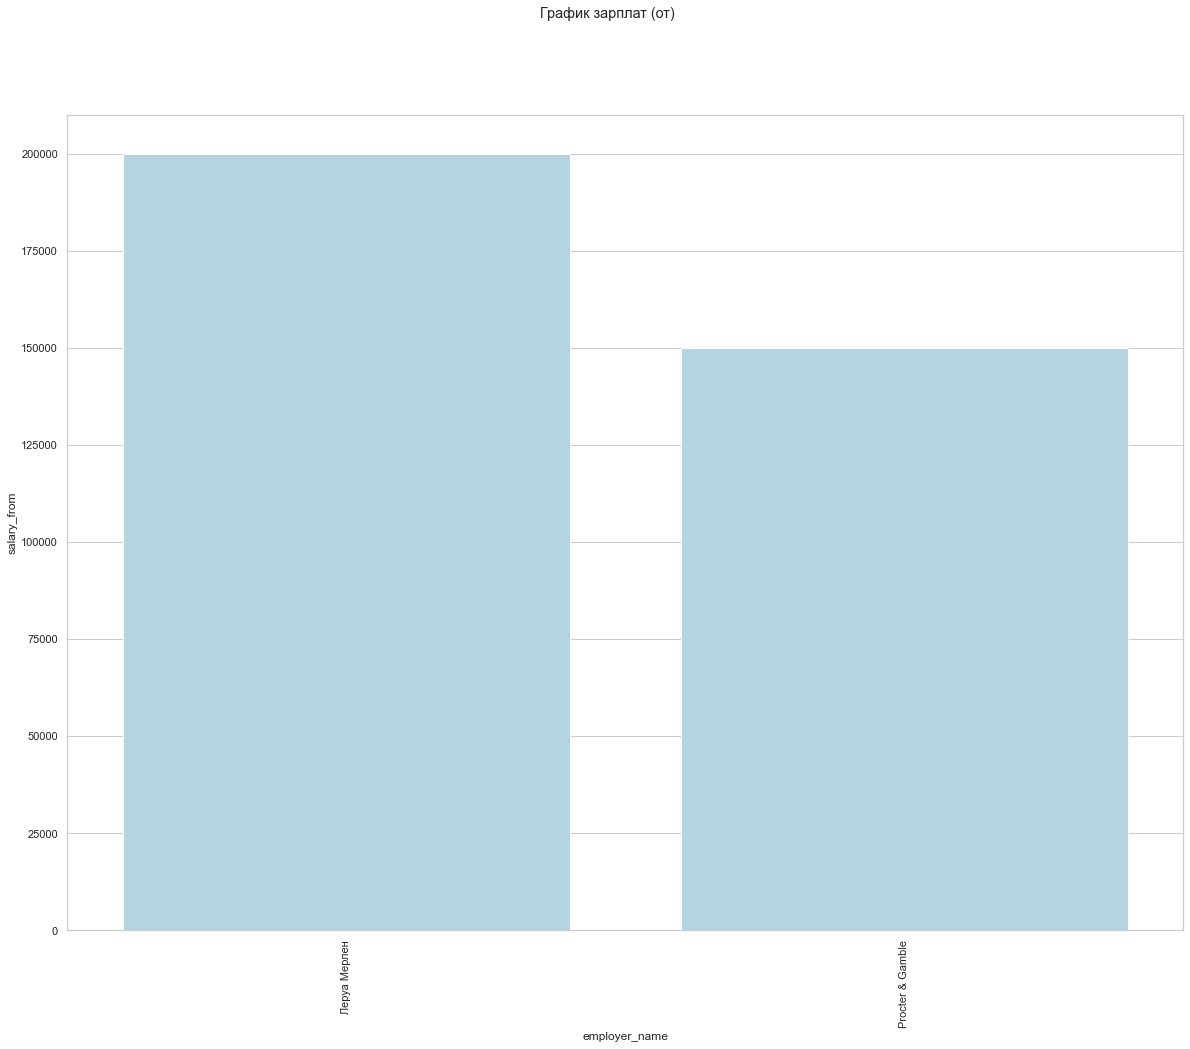

In [45]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20,15))                
title = 'График зарплат (от)'
fig.suptitle(title)
plt.xticks(rotation=90)  
sns.barplot(data=salaries.sort_values(by='salary_from', ascending=False), x='employer_name', y='salary_from', color='lightblue', ax=ax);

In [46]:
salaries

,employer_name,department_name,salary_from
0,Procter & Gamble,"«Procter & Gamble», Технический специалист",150000.0
1,Леруа Мерлен,Леруа Мерлен. Центральный офис,200000.0


### Поищем вакансии

In [47]:
city_vacs = vacancy_df[vacancy_df['city'] == "Москва"]

In [48]:
city_vacs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 2 to 370
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        180 non-null    object 
 1   premium                   180 non-null    bool   
 2   name                      180 non-null    object 
 3   department                52 non-null     object 
 4   has_test                  180 non-null    bool   
 5   response_letter_required  180 non-null    bool   
 6   area                      180 non-null    object 
 7   salary                    23 non-null     object 
 8   type                      180 non-null    object 
 9   address                   88 non-null     object 
 10  response_url              0 non-null      object 
 11  sort_point_distance       0 non-null      object 
 12  published_at              180 non-null    object 
 13  created_at                180 non-null    object 
 14  archived  

In [49]:
city_vacs.head(10)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,...,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,city
2,51045137,False,Data Scientist,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 1000, 'to': 1500, 'currency': 'EUR', ...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-28T14:42:53+0300,2022-01-28T14:42:53+0300,False,...,None,"{'id': 'flexible', 'name': 'Гибкий график'}",306,[],[],[],True,noExperience,Verfacto,NaN,1000.0,1500.0,True,EUR,Москва
6,51346006,False,Младший аналитик / Data scientist,None,True,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Новодмитровская ...",None,None,2022-01-28T14:18:19+0300,2022-01-28T14:18:19+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",58,[],[],[],False,noExperience,ЭКОПСИ Консалтинг,NaN,NaN,NaN,NaN,NaN,Москва
9,51799722,False,Стажер Data Engineer,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-26T16:36:59+0300,2022-01-26T16:36:59+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",121,[],[],[],False,noExperience,Билайн,NaN,NaN,NaN,NaN,NaN,Москва
15,51393158,False,Data Science (junior),"{'id': 'rosbank-599-bezo', 'name': '«РОСБАНК, ...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-24T13:04:55+0300,2022-01-24T13:04:55+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",146,[],[],[],False,noExperience,"РОСБАНК, Societe Generale Group (Russia)","«РОСБАНК, Societe Generale Group»",NaN,NaN,NaN,NaN,Москва
16,50930766,False,Junior data scientist,None,False,True,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Одесская улица',...",None,None,2022-01-24T10:33:51+0300,2022-01-24T10:33:51+0300,False,...,None,"{'id': 'remote', 'name': 'Удаленная работа'}",45,[],[],[],False,noExperience,Интерфакс,NaN,NaN,NaN,NaN,NaN,Москва
18,50689172,False,Data Engineer,"{'id': 'mailru-15478-other', 'name': 'VK'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Ленинградский пр...",None,None,2022-01-26T16:18:26+0300,2022-01-26T16:18:26+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",6,[],[],[],False,noExperience,VK,VK,NaN,NaN,NaN,NaN,Москва
20,50514060,False,Junior Data Engineer,"{'id': 'mailru-15478-od', 'name': 'VK, Социаль...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Ленинградский пр...",None,None,2022-01-21T09:51:54+0300,2022-01-21T09:51:54+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",46,[],[],[],False,noExperience,VK,"VK, Социальные сети, Одноклассники",NaN,NaN,NaN,NaN,Москва
22,49027925,False,Data Engineer (Tinkoff Asia),None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Головинское шосс...",None,None,2022-01-24T08:55:54+0300,2022-01-24T08:55:54+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",9,[],[],[],False,noExperience,Тинькофф,NaN,NaN,NaN,NaN,NaN,Москва
23,51345690,False,Аналитик данных/ data engineer,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-26T09:02:08+0300,2022-01-26T09:02:08+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",33,[],[],[],False,noExperience,Сбербанк,Сбер для экспертов,NaN,NaN,N

### Посмотрим содержание вакансий

Скопируем данные из `city_vacs` и отфильтруем по опыту - без опыта.

In [55]:
vacs_df = city_vacs.copy().reset_index(drop=True).query("experience in ['noExperience']")

In [57]:
vacs_df.head()

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,...,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,city
0,51045137,False,Data Scientist,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 1000, 'to': 1500, 'currency': 'EUR', ...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-28T14:42:53+0300,2022-01-28T14:42:53+0300,False,...,None,"{'id': 'flexible', 'name': 'Гибкий график'}",306,[],[],[],True,noExperience,Verfacto,NaN,1000.0,1500.0,True,EUR,Москва
1,51346006,False,Младший аналитик / Data scientist,None,True,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Новодмитровская ...",None,None,2022-01-28T14:18:19+0300,2022-01-28T14:18:19+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",58,[],[],[],False,noExperience,ЭКОПСИ Консалтинг,NaN,NaN,NaN,NaN,NaN,Москва
2,51799722,False,Стажер Data Engineer,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-26T16:36:59+0300,2022-01-26T16:36:59+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",121,[],[],[],False,noExperience,Билайн,NaN,NaN,NaN,NaN,NaN,Москва
3,51393158,False,Data Science (junior),"{'id': 'rosbank-599-bezo', 'name': '«РОСБАНК, ...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-24T13:04:55+0300,2022-01-24T13:04:55+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",146,[],[],[],False,noExperience,"РОСБАНК, Societe Generale Group (Russia)","«РОСБАНК, Societe Generale Group»",NaN,NaN,NaN,NaN,Москва
4,50930766,False,Junior data scientist,None,False,True,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Одесская улица',...",None,None,2022-01-24T10:33:51+0300,2022-01-24T10:33:51+0300,False,...,None,"{'id': 'remote', 'name': 'Удаленная работа'}",45,[],[],[],False,noExperience,Интерфакс,NaN,NaN,NaN,NaN,NaN,Москва


Выберем столбец `url` со ссылками на вакансии:

In [58]:
vacs_df['url']

0     https://api.hh.ru/vacancies/51045137?host=hh.ru
1     https://api.hh.ru/vacancies/51346006?host=hh.ru
2     https://api.hh.ru/vacancies/51799722?host=hh.ru
3     https://api.hh.ru/vacancies/51393158?host=hh.ru
4     https://api.hh.ru/vacancies/50930766?host=hh.ru
5     https://api.hh.ru/vacancies/50689172?host=hh.ru
6     https://api.hh.ru/vacancies/50514060?host=hh.ru
7     https://api.hh.ru/vacancies/49027925?host=hh.ru
8     https://api.hh.ru/vacancies/51345690?host=hh.ru
9     https://api.hh.ru/vacancies/51487316?host=hh.ru
10    https://api.hh.ru/vacancies/50655160?host=hh.ru
11    https://api.hh.ru/vacancies/51892695?host=hh.ru
12    https://api.hh.ru/vacancies/51654535?host=hh.ru
13    https://api.hh.ru/vacancies/51784863?host=hh.ru
14    https://api.hh.ru/vacancies/51808940?host=hh.ru
15    https://api.hh.ru/vacancies/49775035?host=hh.ru
16    https://api.hh.ru/vacancies/51899468?host=hh.ru
17    https://api.hh.ru/vacancies/51471424?host=hh.ru
18    https://api.hh.ru/vaca

Сделаем запрос по каждой ссылке, выберем поле `description` с описанием вакансии и приведем всё к виду HTML.

In [59]:
vacs = vacs_df['url'].apply(lambda x: HTML(json.loads(requests.get(x).text)['description']))

In [69]:
vacs_df

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,...,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,city,text
0,51045137,False,Data Scientist,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 1000, 'to': 1500, 'currency': 'EUR', ...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-28T14:42:53+0300,2022-01-28T14:42:53+0300,False,...,"{'id': 'flexible', 'name': 'Гибкий график'}",306,[],[],[],True,noExperience,Verfacto,NaN,1000.0,1500.0,True,EUR,Москва,В Data Science команду Verfacto мы ищем специа...
1,51346006,False,Младший аналитик / Data scientist,None,True,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Новодмитровская ...",None,None,2022-01-28T14:18:19+0300,2022-01-28T14:18:19+0300,False,...,"{'id': 'fullDay', 'name': 'Полный день'}",58,[],[],[],False,noExperience,ЭКОПСИ Консалтинг,NaN,NaN,NaN,NaN,NaN,Москва,"Мы команда HR-Marketing ЭКОПСИ Консалтинг, зан..."
2,51799722,False,Стажер Data Engineer,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-26T16:36:59+0300,2022-01-26T16:36:59+0300,False,...,"{'id': 'fullDay', 'name': 'Полный день'}",121,[],[],[],False,noExperience,Билайн,NaN,NaN,NaN,NaN,NaN,Москва,Мы объявляем набор на оплачиваемую стажировку ...
3,51393158,False,Data Science (junior),"{'id': 'rosbank-599-bezo', 'name': '«РОСБАНК, ...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-01-24T13:04:55+0300,2022-01-24T13:04:55+0300,False,...,"{'id': 'fullDay', 'name': 'Полный день'}",146,[],[],[],False,noExperience,"РОСБАНК, Societe Generale Group (Russia)","«РОСБАНК, Societe Generale Group»",NaN,NaN,NaN,NaN,Москва,Росбанк – универсальный банк в составе междуна...
4,50930766,False,Junior data scientist,None,False,True,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Одесская улица',...",None,None,2022-01-24T10:33:51+0300,2022-01-24T10:33:51+0300,False,...,"{'id': 'remote', 'name': 'Удаленная работа'}",45,[],[],[],False,noExperience,Интерфакс,NaN,NaN,NaN,NaN,NaN,Москва,Международная информационная группа «Интерфакс...
5,50689172,False,Data Engineer,"{'id': 'mailru-15478-other', 'name': 'VK'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Ленинградский пр...",None,None,2022-01-26T16:18:26+0300,2022-01-26T16:18:26+0300,False,...,"{'id': 'fullDay', 'name': 'Полный день'}",6,[],[],[],False,noExperience,VK,VK,NaN,NaN,NaN,NaN,Москва,Чем предстоит заниматься: настройка первичной...
6,50514060,False,Junior Data Engineer,"{'id': 'mailru-15478-od', 'name': 'VK, Социаль...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Ленинградский пр...",None,None,2022-01-21T09:51:54+0300,2022-01-21T09:51:54+0300,False,...,"{'id': 'fullDay', 'name': 'Полный день'}",46,[],[],[],False,noExperience,VK,"VK, Социальные сети, Одноклассники",NaN,NaN,NaN,NaN,Москва,"В команду, занимающуюся анализом и хранением д..."
7,49027925,False,Data Engineer (Tinkoff Asia),None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Головинское шосс...",None,None,2022-01-24T08:55:54+0300,2022-01-24T08:55:54+0300,False,...,"{'id': 'fullDay', 'name': 'Полный день'}",9,[],[],[],False,noExperience,Тинькофф,NaN,NaN,NaN,NaN,NaN,Москва,Тинькофф собирает команду для международной эк...
8,51345690,False,Аналитик данных/ data engin

Посмотрим на отображение на примере ссылки с индексом 1:

In [60]:
display(vacs.iloc[1])

Напишем код, который позволит нам по клику показывать описания вакансий прямо в ячейке и ссылкой на оригинал на hh:

In [72]:
button = widgets.Button(description="show")
output = widgets.Output()

display(button, output)

counter = 0
def on_clicked(b):
    with output:
        try:
            global counter
            clear_output()
            print('№ вакансии: ', counter)
            display(HTML("<h1>" + str(vacs_df['name'][counter]) + ' в ' + str(vacs_df['employer_name'][counter]) + "</h1>"))
            display(vacs[counter])
            display(HTML('<a href="' + str(vacs_df['alternate_url'][counter]) + '" target="_blank">Ссылка на вакансию</a>'))
            counter += 1
        except Exception as e:
            print('Вакансии закончились')
            
button.on_click(on_clicked)

Button(description='show', style=ButtonStyle())

Output()

Таким образом, корректируя входные параметры для поиска, можно подбирать нужные вакансии и откликаться на них.

Изначально парсер вакансий написан именно для этой цели. В дальнейшем, с более глубоким изучением API можно улучшить и расширить функциональность.